## Expectation Reflection for Classification

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
def synthesize_data(l,n,g,data_type='discrete'):        
    if data_type == 'binary':
        X = np.sign(np.random.rand(l,n)-0.5)
        w = np.random.normal(0.,g/np.sqrt(n),size=n)
        
    if data_type == 'continuous':
        X = 2*np.random.rand(l,n)-1
        w = np.random.normal(0.,g/np.sqrt(n),size=n)
        
    if data_type == 'categorical':        
        from sklearn.preprocessing import OneHotEncoder
        m = 5 # categorical number for each variables
        # initial s (categorical variables)
        s = np.random.randint(0,m,size=(l,n)) # integer values
        onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
        X = onehot_encoder.fit_transform(s)
        w = np.random.normal(0.,g/np.sqrt(n),size=n*m)
        
    h = X.dot(w)
    p = 1/(1+np.exp(-2*h)) # kinetic
    #p = 1/(1+np.exp(-h))  # logistic regression
    y = np.sign(p - np.random.rand(l))
    return w,X,y

In [4]:
l = 1000
n = 20
g = 2.

w0,X,y = synthesize_data(l,n,g,data_type='binary')

In [5]:
h0,w = ER.fit(X,y,niter_max=100,regu=0.001)

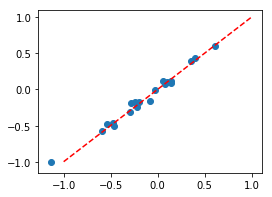

In [6]:
plt.figure(figsize=(4,3))
plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w)

In [9]:
from scipy.sparse.linalg import svds
#from numpy.linalg.svd import svds as svdsnp

def fit(x,y,niter_max=500,regu=0.1):
    #print(niter_max)    

    n = x.shape[1]
    
    x_av = np.mean(x,axis=0)
    dx = x - x_av
    c = np.cov(dx,rowvar=False,bias=True)
    #c += regu*np.identity(n)
    #c_inv = linalg.inv(c)
    
    #---------------------------------------------------------
    # 2018.06.07: find c_inv
    #x_oh_svd = svds(x, k=n) 
    x_oh_svd = np.linalg.svd(x, full_matrices=True)
    
    x_oh_sv_pinv = x_oh_svd[1].copy()
    zero_sv = np.isclose(x_oh_sv_pinv, 0)
    x_oh_sv_pinv[zero_sv] = 0
    x_oh_sv_pinv[~zero_sv] = 1. / x_oh_sv_pinv[~zero_sv]
    x_oh_pinv = (x_oh_svd[2].T, x_oh_sv_pinv[:, np.newaxis], x_oh_svd[0].T)
            
    def solve(u):
        w = x_oh_pinv[2].dot(u)
        w = np.multiply(x_oh_pinv[1], w)
        w = x_oh_pinv[0] * w
        return w           
    #---------------------------------------------------------

    # initial values
    h0 = 0.
    w = np.random.normal(0.0,1./np.sqrt(n),size=(n))
    
    cost = np.full(niter_max,100.)
    for iloop in range(niter_max):
        h = h0 + x.dot(w)
        y_model = np.tanh(h)    

        # stopping criterion
        cost[iloop] = ((y[:]-y_model[:])**2).mean()
        if iloop>0 and cost[iloop] >= cost[iloop-1]: break

        # update local field
        t = h!=0    
        h[t] *= y[t]/y_model[t]
        h[~t] = y[~t]

        # find w from h    
        h_av = h.mean()
        dh = h - h_av 
        dhdx = dh[:,np.newaxis]*dx[:,:]
        dhdx_av = dhdx.mean(axis=0)
        
        # 2019.06.07: find w from h
        #w = c_inv.dot(dhdx_av)        
        w = solve(h)     

        h0 = h_av - x_av.dot(w)
        
    return h0,w

In [10]:
h0,w2 = fit(X,y,niter_max=100,regu=0.001)

ValueError: operands could not be broadcast together with shapes (20,20) (20,1000) 

In [ ]:
plt.figure(figsize=(4,3))
plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w2)